In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "/root/workspace/var-wold/data/memetracker/memetracker-top100-clean.pickle.gz"

Load the dataset

In [5]:
dataset = tsvar.preprocessing.MemeTrackerDataset(INPUT_PATH)
dataset.data.Timestamp /= 426.3722723177017

Visualize the dataset

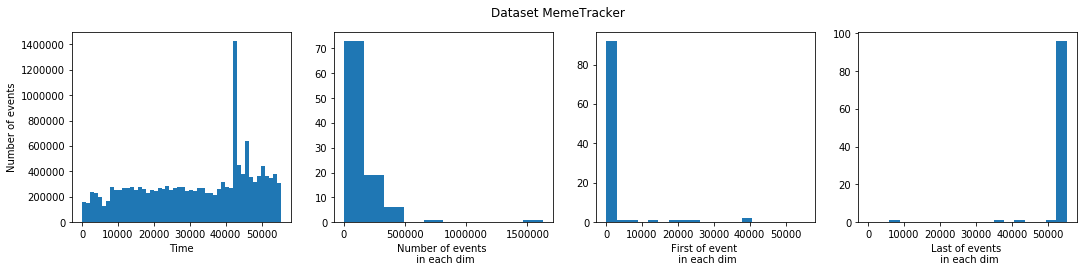

In [6]:
start_time = dataset.data.Timestamp.min()
end_time = dataset.data.Timestamp.max()
events_all, graph_all = dataset.sample(start_time, end_time)

fig, axs = plt.subplots(1, 4, figsize=(18, 3.5))

axs[0].hist(np.hstack(events_all.values()), bins=50)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Number of events')

axs[1].hist(list(map(len, events_all.values())))
axs[1].set_xlabel('Number of events \n in each dim')

axs[2].hist(list(map(min, events_all.values())), bins=np.linspace(start_time, end_time, 20))
axs[2].set_xlabel('First of event \n in each dim')

axs[3].hist(list(map(max, events_all.values())), bins=np.linspace(start_time, end_time, 20))
axs[3].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset MemeTracker");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(events_all):,d}")
print(f"    Num. of events: {sum(map(len, events_all.values())):,d}")
print(f"               %NZ: {100 * graph_all.number_of_edges() / (graph_all.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, events_all.values())))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 15,168,771
               %NZ: 9.85%

Stats. of num. of events per dim:
count    1.000000e+02
mean     1.516877e+05
std      1.937080e+05
min      1.723000e+03
25%      7.706900e+04
50%      1.057855e+05
75%      1.740125e+05
max      1.624572e+06
dtype: float64


## Sample train and test sets

In [8]:
chunk_idx = 2
chunk_total = 20

t0 = dataset.data.Timestamp.min()
t1 = dataset.data.Timestamp.max()
train_start = t0 + (t1 - t0) * chunk_idx / chunk_total
train_end = t0 + (t1 - t0) * (chunk_idx + 1) / chunk_total
test_end = t0 + (t1 - t0) * (chunk_idx + 2) / chunk_total

train_events, train_graph, test_events, test_graph = dataset.build_train_test(train_start, train_end, test_end)
nodelist = sorted(train_events.keys())

adjacency_true = nx.adjacency_matrix(train_graph, nodelist).toarray()
train_events = [train_events[v] for v in nodelist]
test_events = [test_events[v] for v in nodelist]

print()
print('Training set')
print('------------')
print(f"Num. of dimensions: {len(train_events):,d}")
print(f"    Num. of events: {sum(map(len, train_events)):,d}")
print(f"Observation window: [{min(map(min, train_events)):.2f}, {max(map(max, train_events)):.2f}]")
print(f"               %NZ: {100 * train_graph.number_of_edges() / (train_graph.number_of_nodes() ** 2):.2f}%")
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, train_events)))
print(pd.Series(num_jumps_per_dim).describe())

print()
print('Test set')
print('--------')
print(f"Num. of dimensions: {len(test_events):,d}")
print(f"    Num. of events: {sum(map(len, test_events)):,d}")
print(f"Observation window: [{min(map(min, test_events)):.2f}, {max(map(max, test_events)):.2f}]")
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, test_events)))
print(pd.Series(num_jumps_per_dim).describe())


test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events)


Training set
------------
Num. of dimensions: 87
    Num. of events: 439,439
Observation window: [0.06, 2765.95]
               %NZ: 3.45%
Stats. of num. of events per dim:
count       87.000000
mean      5051.022989
std       7226.410542
min          1.000000
25%        991.000000
50%       3839.000000
75%       6909.000000
max      60379.000000
dtype: float64

Test set
--------
Num. of dimensions: 87
    Num. of events: 646,538
Observation window: [0.25, 2765.97]
Stats. of num. of events per dim:
count       87.000000
mean      7431.471264
std      10110.486740
min          1.000000
25%        520.500000
50%       4997.000000
75%       9282.000000
max      71799.000000
dtype: float64


## Run inference

### Run VI

In [63]:
dim = len(train_events)

# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 10.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 11.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(train_events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('    mean:', as_pr[0,0] / ar_pr[0,0])
print('variance:', as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('    mean:', br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance:', br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
    mean: 0.1
variance: 0.01
BETA:
-----
    mean: 1.0
variance: 0.1111111111111111


In [64]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariationalOther(verbose=True)
vi_model.observe(train_events)

In [65]:
class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __call__(self, learner_obj, end=None, force=False):
        super().__call__(learner_obj, end, force)
        t = learner_obj._n_iter_done + 1
        if (t % self.print_every == 0) or force:
            # Extract mean of posteriors
            mu_hat = learner_obj._as_po[0, :] / learner_obj._ar_po[0, :]
            adj_hat = learner_obj._as_po[1:, :] / learner_obj._ar_po[1:, :]
            beta_hat = learner_obj._br_po[:, :] / (learner_obj._bs_po[:, :] + 1) + 1
            coeffs_hat = torch.tensor(np.hstack((
                mu_hat, beta_hat.flatten(), adj_hat.flatten()
            )))
            
            loglik = float(test_model.log_likelihood(coeffs_hat)) / sum(map(len, test_events))
            print(f'vi_ll: {loglik:.2f}')
            

callback = MyCallback(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true, acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
             max_iter=10, tol=1e-5, callback=callback)

a_mean: min:+4.47e-04, max:+2.14e+00
b_mean: min:+7.96e-01, max:+1.62e+01
iter:     1 | dx: +2.0436e+00 | f1-score: 0.06 | relerr: 1.05e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 3.77e+01     
vi_ll: 0.15
a_mean: min:+5.06e-04, max:+3.41e+00
b_mean: min:+5.52e-01, max:+5.46e+00
iter:     2 | dx: +1.2630e+00 | f1-score: 0.06 | relerr: 1.15e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.05e+00     
vi_ll: 0.26
a_mean: min:+5.18e-04, max:+4.03e+00
b_mean: min:+2.97e-01, max:+5.00e+00
iter:     3 | dx: +6.1942e-01 | f1-score: 0.07 | relerr: 1.10e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.80e+00     
vi_ll: 0.22
a_mean: min:+5.22e-04, max:+4.48e+00
b_mean: min:+1.39e-01, max:+5.05e+00
iter:     4 | dx: +4.5671e-01 | f1-score: 0.07 | relerr: 1.07e-01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 8.42e+00     
vi_ll: 0.18
a_mean: min:+5.24e-04, max:+4.78e+00
b_mean: min:+7.00e-02, max:+5.04e+00
iter:     5 | dx: +4.3068e-01 | f1-score: 0.07 | relerr: 1.05e-01 

RuntimeError: Negative Beta parameter!

In [62]:
vi_model._br_po.min(), vi_model._br_po.max()

(1.0386935779275797e-10, 4.1041741305588124e-08)

In [30]:
vi_model._bs_po, vi_model._br_po, vi_model._b_x0, vi_model._b_xn = tsvar.models._wold_var_AltDeltaInit._update_beta(
    as_po=vi_model._as_po,
    ar_po=vi_model._ar_po,
    zp_po=vi_model._zp_po,
    bs_pr=vi_model._bs_pr,
    br_pr=vi_model._br_pr,
    dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj,
)

Beta optim failed for x0, swtich to bin search
Beta optim failed for xn, switch to bin search


In [27]:
zp_po = tsvar.models._wold_var_AltDeltaInit._update_z(
    as_po=vi_model._as_po,
    ar_po=vi_model._ar_po,
    bs_po=vi_model._bs_po,
    br_po=vi_model._br_po,
    dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj,
)

In [14]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

coeffs_hat = torch.tensor(np.hstack((
    mu_hat, beta_hat.flatten(), adj_hat.flatten()
)))


vi_ll = float(test_model.log_likelihood(coeffs_hat)) / sum(map(len, test_events))
vi_ll 

-0.0963845525536336

In [34]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1
model_name = type(vi_model).__name__

adj_hat = adj_hat
#adj_hat = adj_hat / beta_hat

#diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
#adjacency_true_zero_diag = adjacency_true.copy()
#adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.3)


========== Method: WoldModelVariationalOther

Accuracy: 0.96

Edge counts
------------
Pred: 147.00
True: 161.00

Error counts
------------
 True Positive: 8.00
False Positive: 139.00
 True Negative: 7800.00
False Negative: 153.00

Error rates
-----------
 True Positive Rate: 0.05
False Positive Rate: 0.02
 True Negative Rate: 0.98
False Negative Rate: 0.95

F-Score
-------
 F1-Score: 0.05
Precision: 0.05
   Recall: 0.05

Precision@k
-----------
 Prec@5: 0.20
Prec@10: 0.30
Prec@20: 0.25

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.03870967741935484
10 0.020967741935483872
20 0.012903225806451613



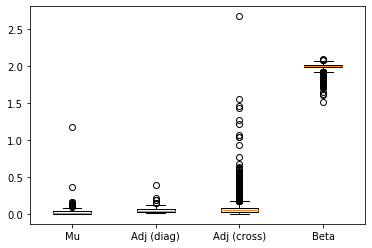

In [15]:
diag_mask = np.eye(dim).astype(bool)
plt.boxplot([mu_hat, adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()],
            labels=['Mu', 'Adj (diag)', 'Adj (cross)', 'Beta']);

---

### Run GB

In [25]:
import gb
import time

dim = len(train_events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0 / len(train_events),
    num_iter=10000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=48,
)
granger_model.fit(train_events)

In [26]:
mu_hat = granger_model.mu_
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * granger_model.beta_
coeffs_hat = torch.tensor(np.hstack((
    granger_model.mu_, beta_hat.flatten(), adj_hat.flatten()
)))

gb_ll = float(test_model.log_likelihood(coeffs_hat)) / sum(map(len, test_events))
gb_ll 

-0.35313515841735715

In [27]:
mu_hat = granger_model.mu_
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * granger_model.beta_
model_name = type(granger_model).__name__

adj_hat = adj_hat
#adj_hat = adj_hat / beta_hat

#diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
#adjacency_true_zero_diag = adjacency_true.copy()
#adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.01)


========== Method: GrangerBusca

Accuracy: 0.97

Edge counts
------------
Pred: 185.00
True: 161.00

Error counts
------------
 True Positive: 49.00
False Positive: 136.00
 True Negative: 7803.00
False Negative: 112.00

Error rates
-----------
 True Positive Rate: 0.30
False Positive Rate: 0.02
 True Negative Rate: 0.98
False Negative Rate: 0.70

F-Score
-------
 F1-Score: 0.28
Precision: 0.26
   Recall: 0.30

Precision@k
-----------
 Prec@5: 0.20
Prec@10: 0.40
Prec@20: 0.50

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.3096774193548385
10 0.17903225806451603
20 0.08951612903225802



---

In [42]:
print(vi_ll)
print(gb_ll)

NameError: name 'vi_ll' is not defined